<a href="https://colab.research.google.com/github/zw2497/Cycle_GAN_Tutorial/blob/master/cycle_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip -q install tensorflow-gpu==2.0.0-alpha0

# Import TensorFlow and other libraries

In [0]:
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [0]:
PATH = '/content/datasets/apple2orange/'

In [0]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    return image

In [35]:
os.path.join(PATH, 'trainA/n07740461_10067.jpg')

'/content/datasets/apple2orange/trainA/n07740461_10067.jpg'

(256, 256, 3)


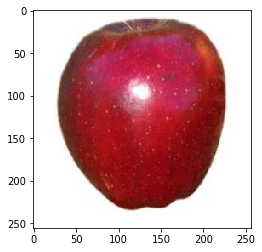

In [42]:
inp = load(os.path.join(PATH, 'trainA/n07740461_10067.jpg'))
print(inp.shape)
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)

In [41]:
inp.shape

TensorShape([256, 256, 3])

# Load and prepare the dataset

In [0]:
%%bash
mkdir datasets
FILE=apple2orange

if [[ $FILE != "ae_photos" && $FILE != "apple2orange" && $FILE != "summer2winter_yosemite" &&  $FILE != "horse2zebra" && $FILE != "monet2photo" && $FILE != "cezanne2photo" && $FILE != "ukiyoe2photo" && $FILE != "vangogh2photo" && $FILE != "maps" && $FILE != "cityscapes" && $FILE != "facades" && $FILE != "iphone2dslr_flower" && $FILE != "ae_photos" ]]; then
    echo "Available datasets are: apple2orange, summer2winter_yosemite, horse2zebra, monet2photo, cezanne2photo, ukiyoe2photo, vangogh2photo, maps, cityscapes, facades, iphone2dslr_flower, ae_photos"
    exit 1
fi

URL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip
ZIP_FILE=./datasets/$FILE.zip
TARGET_DIR=./datasets/$FILE/
wget -N $URL -O $ZIP_FILE
mkdir $TARGET_DIR
unzip $ZIP_FILE -d ./datasets/
rm $ZIP_FILE

# Model Building

# Generator

Refer to: https://www.tensorflow.org/alpha/tutorials/generative/pix2pix

In [0]:
def downsample(filters, size=4, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

W0420 05:29:02.298233 140216808327040 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 128, 128, 3)


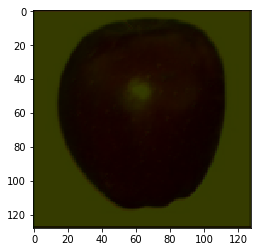

In [165]:
# 256,256,3 => 1,256,256,3 => 1,128,128,3 => 128, 128, 3
down_model = downsample(3)
down_result = down_model(tf.expand_dims(inp, 0))
plt.figure()
plt.imshow(down_result.numpy().reshape(128, 128, 3)/255.0)
print(down_result.shape)

In [0]:
def upsample(filters, size=4, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [158]:
up_model = upsample(3)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [0]:
def Generator():
    
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128), # (bs, 64, 64, 128)
        downsample(256), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

# Discriminator

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model